In [5]:
from nilearn import datasets
import numpy as np
from scipy import stats
import torch
from torch_geometric.data import Data
import matplotlib.colors as mcol
from matplotlib import cm
from ot.gromov import fgw_barycenters
from scipy.sparse.csgraph import shortest_path

# Load data

In [6]:
from nilearn import datasets

abide = datasets.fetch_abide_pcp(
    data_dir="/Users/balazsmorvay/Downloads/nilearn_data",
    derivatives="rois_cc200",
    pipeline="cpac",
    band_pass_filtering=True,
    global_signal_regression=True,
    quality_checked=True,
)

[fetch_abide_pcp] Dataset found in /Users/balazsmorvay/Downloads/nilearn_data/ABIDE_pcp


# Utilities

In [7]:
def corr_fisher_z(X):  # X: (T, N) ROI time-series
    C = np.corrcoef(X, rowvar=False)          # (N, N)
    C = np.clip(C, -0.999999, 0.999999)
    Z = np.arctanh(C)                         # Fisher z
    np.fill_diagonal(Z, 0.0)
    return Z

def top_p_sparsify(W, p=0.10, keep_positive=True):
    """Keep top p% absolute (or positive) weights per *whole matrix*."""
    Wc = W.copy()
    if keep_positive:
        Wc[Wc < 0] = 0
    flat = Wc.flatten()
    k = max(1, int(len(flat) * p))
    thr = np.partition(flat, -k)[-k]  # global threshold
    A = (Wc >= thr).astype(float) * Wc
    # symmetrize
    A = 0.5 * (A + A.T)
    np.fill_diagonal(A, 0.0)
    return A

def make_node_features(Z, mode='corr_row'):
    """
    'corr_row' -> node i feature = i-th row of Z (NeuroGraph style)
    'none'     -> no explicit node features (ones)
    """
    N = Z.shape[0]
    if mode == 'corr_row':
        X = Z.copy()
        np.fill_diagonal(X, 0.0)
        return X
    return np.ones((N, 1), dtype=float)

def to_pyg(A, X, y=None, meta=None):
    if Data is None:
        return dict(edge_index=None, edge_weight=None, x=X, y=y, meta=meta)
    # build edge_index/weight from upper triangle
    i, j = np.where(np.triu(A, 1) > 0)
    w = A[i, j]
    # make undirected (i<->j)
    ei = np.vstack([np.hstack([i, j]), np.hstack([j, i])])
    ew = np.hstack([w, w]).astype(np.float32)
    x = torch.tensor(X, dtype=torch.float32)
    data = Data(x=x,
                edge_index=torch.tensor(ei, dtype=torch.long),
                edge_weight=torch.tensor(ew),
                y=None if y is None else torch.tensor([y], dtype=torch.long))
    data.meta = meta
    return data

def graph_colors(nx_graph, attr_name = "attr_name", vmin=0, vmax=7):
    cnorm = mcol.Normalize(vmin=vmin, vmax=vmax)
    cpick = cm.ScalarMappable(norm=cnorm, cmap="viridis")
    cpick.set_array([])
    val_map = {}
    for k, v in nx.get_node_attributes(nx_graph, attr_name).items():
        val_map[k] = cpick.to_rgba(v)
    colors = []
    for node in nx_graph.nodes():
        colors.append(val_map[node])
    return colors

# Build one graph per subject

In [8]:
graphs = []
for i, ts in enumerate(abide.rois_cc200):
    pheno = abide.phenotypic.iloc[i]
    # 3.1 connectivity (Fisher-z of Pearson corr)
    Z = corr_fisher_z(ts)
    # 3.2 sparsify like NeuroGraph (e.g., top 10% positive edges)
    A = top_p_sparsify(Z, p=0.10, keep_positive=True)
    # 3.3 node features (corr row vectors)
    X = make_node_features(Z, mode='corr_row')
    # 3.4 label: ASD(1)/HC(2) in ABIDE PCP; convert to 0/1
    dx = pheno.get('DX_GROUP')
    y = None if dx is None else int(dx == 1)  # 1=ASD -> 1, 2=HC -> 0
    # 3.5 site/domain
    site = pheno.get('SITE_ID', pheno.get('SITE_NAME', 'NA'))
    graphs.append(to_pyg(A, X, y=y, meta={'site': site, 'age': pheno.get('AGE_AT_SCAN')}))

print(f'Built {len(graphs)} graphs (static). Example meta:', graphs[0].meta if graphs else None)

/Users/balazsmorvay/PycharmProjects/NeuroGraph/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/balazsmorvay/PycharmProjects/NeuroGraph/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Built 871 graphs (static). Example meta: {'site': 'PITT', 'age': np.float64(24.45)}


In [9]:
len(graphs), graphs[0]
# Data(
#    x=[200, 200], # node features: 200 ROIs correlation matrix
#    edge_index=[2, 4000], # directed edge list, 4000 directed = 2000 undirected, approx. 10% of all edges
#    y=[1], # label: 1=ASD, 0=HC
#    edge_weight=[4000], # edge weights: Fisher-z correlation values
#    meta={
#      site='PITT',
#      age=13.73,
#    }
#  )

(871,
 Data(
   x=[200, 200],
   edge_index=[2, 4000],
   y=[1],
   edge_weight=[4000],
   meta={
     site='PITT',
     age=24.45,
   }
 ))

# PyG to NetworkX graphs

In [10]:
from torch_geometric.utils import to_networkx
import networkx as nx

nx_graphs = []
for g in graphs:
    G = to_networkx(
        g,
        node_attrs=['x'],                 # keep node feature vectors
        edge_attrs=['edge_weight'],       # keep weights
        to_undirected=True,               # collapse i→j and j→i duplicates
        remove_self_loops=True
    )
    # stash graph-level info
    G.graph.update({
        'label': int(g.y.item()) if g.y is not None else None,
        **(g.meta or {})
    })
    nx_graphs.append(G)

# Example: first graph
G0 = nx_graphs[0]
print(type(G0), G0.number_of_nodes(), G0.number_of_edges())
# node feature of ROI 0: G0.nodes[0]['x']  -> numpy/torch vector length 200
# edge weight: G0[u][v]['edge_weight']

<class 'networkx.classes.graph.Graph'> 200 2000


In [18]:
# Get all sites and their cardinality from nx_graphs
from collections import Counter

sites = [G.graph['site'] for G in nx_graphs]
site_counts = Counter(sites)

# Get labels for each graph
labels = [G.graph['label'] for G in nx_graphs]

# Count labels per site
site_label_counts = {}
for G in nx_graphs:
    site = G.graph['site']
    label = G.graph['label']
    if site not in site_label_counts:
        site_label_counts[site] = {0: 0, 1: 0}
    site_label_counts[site][label] += 1

# Sort by cardinality (descending)
sorted_sites = sorted(site_counts.items(), key=lambda x: x[1], reverse=True)

print("Site Cardinality and Label Distribution:")
print("-" * 60)
print(f"{'Site':<20s} {'Total':>6s} {'Label 0':>8s} {'Label 1':>8s}")
print("-" * 60)
for site, count in sorted_sites:
    label_0 = site_label_counts[site][0]
    label_1 = site_label_counts[site][1]
    print(f"{site:<20s} {count:>6d} {label_0:>8d} {label_1:>8d}")
print("-" * 60)
print(f"Total sites: {len(site_counts)}")
print(f"Total graphs: {len(nx_graphs)}")
print(f"Total Label 0: {sum(1 for l in labels if l == 0)}")
print(f"Total Label 1: {sum(1 for l in labels if l == 1)}")


Site Cardinality and Label Distribution:
------------------------------------------------------------
Site                  Total  Label 0  Label 1
------------------------------------------------------------
NYU                     172       98       74
UM_1                     86       52       34
USM                      67       24       43
UCLA_1                   64       27       37
PITT                     50       26       24
MAX_MUN                  46       27       19
TRINITY                  44       25       19
YALE                     41       19       22
UM_2                     34       21       13
KKI                      33       21       12
OLIN                     28       14       14
LEUVEN_1                 28       14       14
LEUVEN_2                 28       16       12
SDSU                     27       19        8
SBL                      26       14       12
OHSU                     25       13       12
STANFORD                 25       13       12
UCLA_2   

In [ ]:
len(G0.nodes[0]['x']), g.y.item()

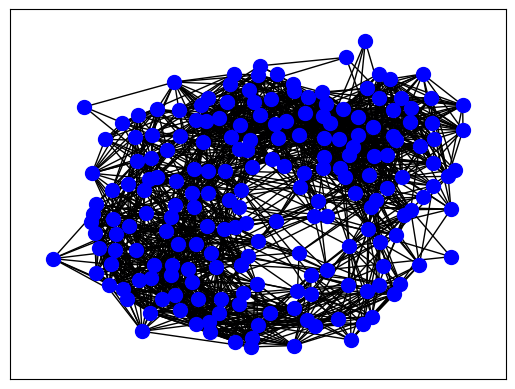

In [13]:
pos = nx.kamada_kawai_layout(G0)
nx.draw_networkx(
    G0,
    pos=pos,
    node_color="blue",
    with_labels=False,
    node_size=100,
)

# Compute FGW barycenter

In [14]:
nx.get_node_attributes(G0, "label")

{}

In [15]:
# num_graphs x num_nodes x 1
Ys = [
    g.graph['label'] for g in nx_graphs
] # Node attributes
len(Ys)

871

In [16]:
Cs = [shortest_path(nx.adjacency_matrix(g).toarray()) for g in nx_graphs] # Shortest paths from each node to each node
ps = [np.ones(len(g.nodes())) / len(g.nodes()) for g in nx_graphs] # Uniform weights on the nodes
Ys = [
    np.array([v for (k, v) in nx.get_node_attributes(g, "x").items()]).reshape(
        -1, 1
    )
    for g in nx_graphs
] # Node attributes
lambdas = np.array([np.ones(len(Ys)) / len(Ys)]).ravel()
# sizebary = 200 * len(nx_graphs) # we choose a barycenter with 15 nodes

A, C, log = fgw_barycenters(sizebary, Ys, Cs, ps, lambdas, alpha=0.95, log=True) # Returns: feature matrix, structure matrix and log dictionary

NameError: name 'sizebary' is not defined